# Poisson regression and non-normal loss
- 데이터셋에서 로그-선형 포아송 회귀의 사용을 보임
- 일반적인 최소제곱 오차로 적합된 선형 모델과 포아송 손실로 적합된 비선형 GBRT 모델과 비교

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## The French Motor Thrid-party Liability Claims dataset

In [1]:
from sklearn.datasets import fetch_openml

df = fetch_openml(data_id=41214, as_frame=True).frame
df

c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


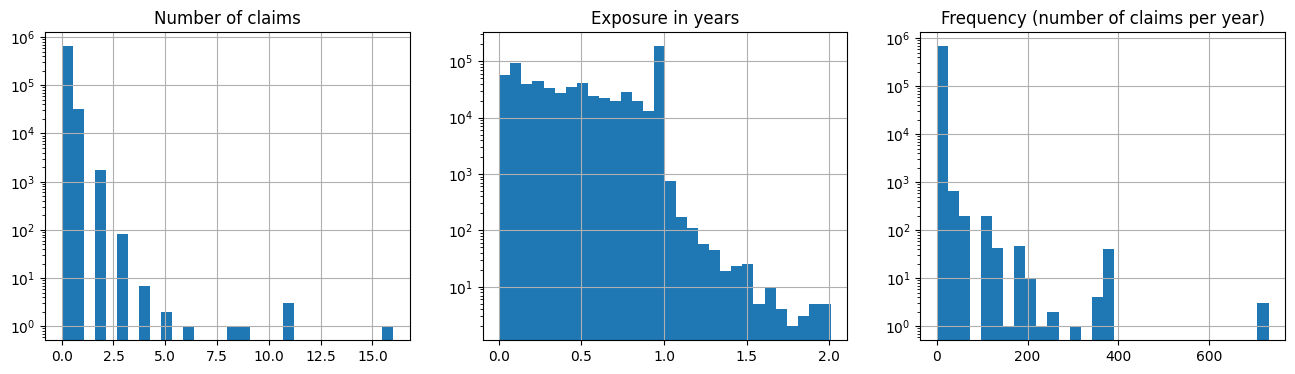

In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

## A constant prediction baseline

In [6]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [7]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_poisson_deviance,
    mean_squared_error,
)


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # 포아송 손실에 대해서는 비양수 예측값은 무효
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


## (Generalized) linear models

In [8]:
from sklearn.linear_model import Ridge

ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [9]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.597


In [10]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky")),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


## Gradient Boosting Regression Trees for Poisson regression

In [11]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.557
MAE: 0.183
mean Poisson deviance: 0.573


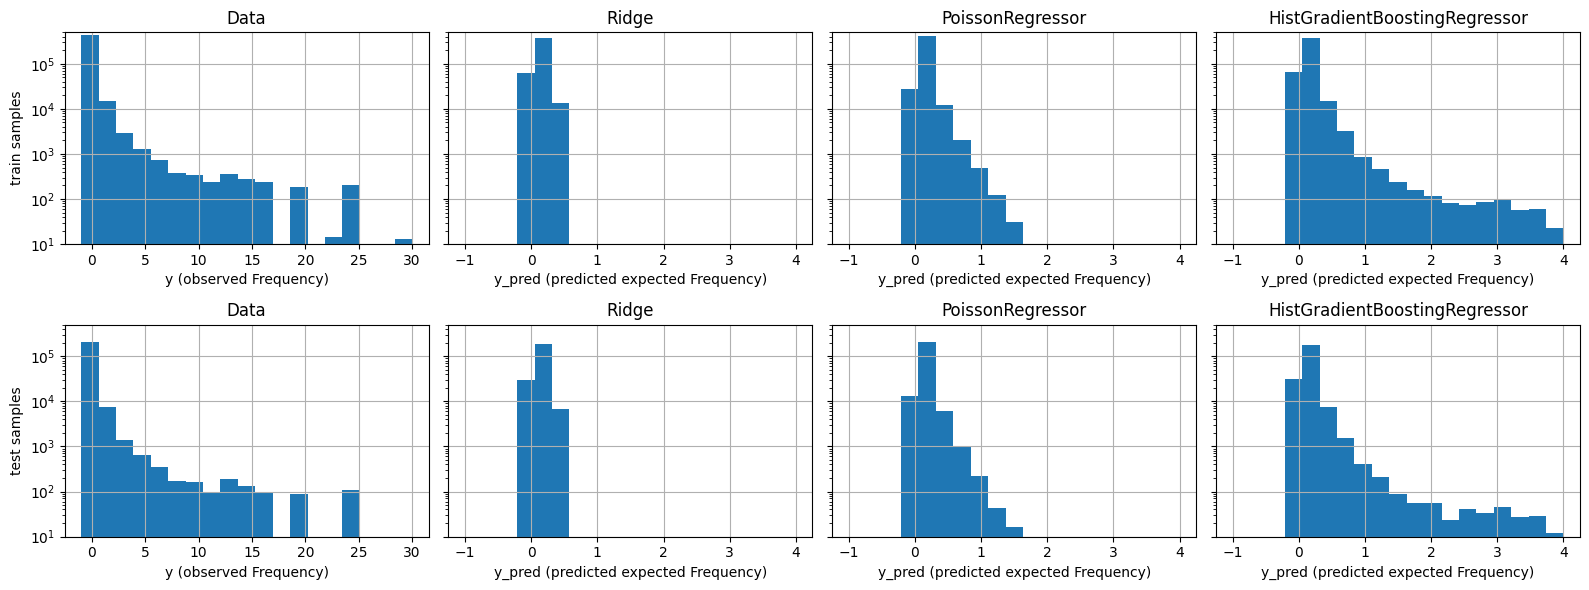

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

## Evaluation of the calibration of predictions

Actual number of claims: 11935.0
Predicted number of claims by Ridge(alpha=1e-06): 11933.4
Predicted number of claims by PoissonRegressor(alpha=1e-12, solver='newton-cholesky'): 11932.0
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12079.8
Predicted number of claims by DummyRegressor(): 11931.2


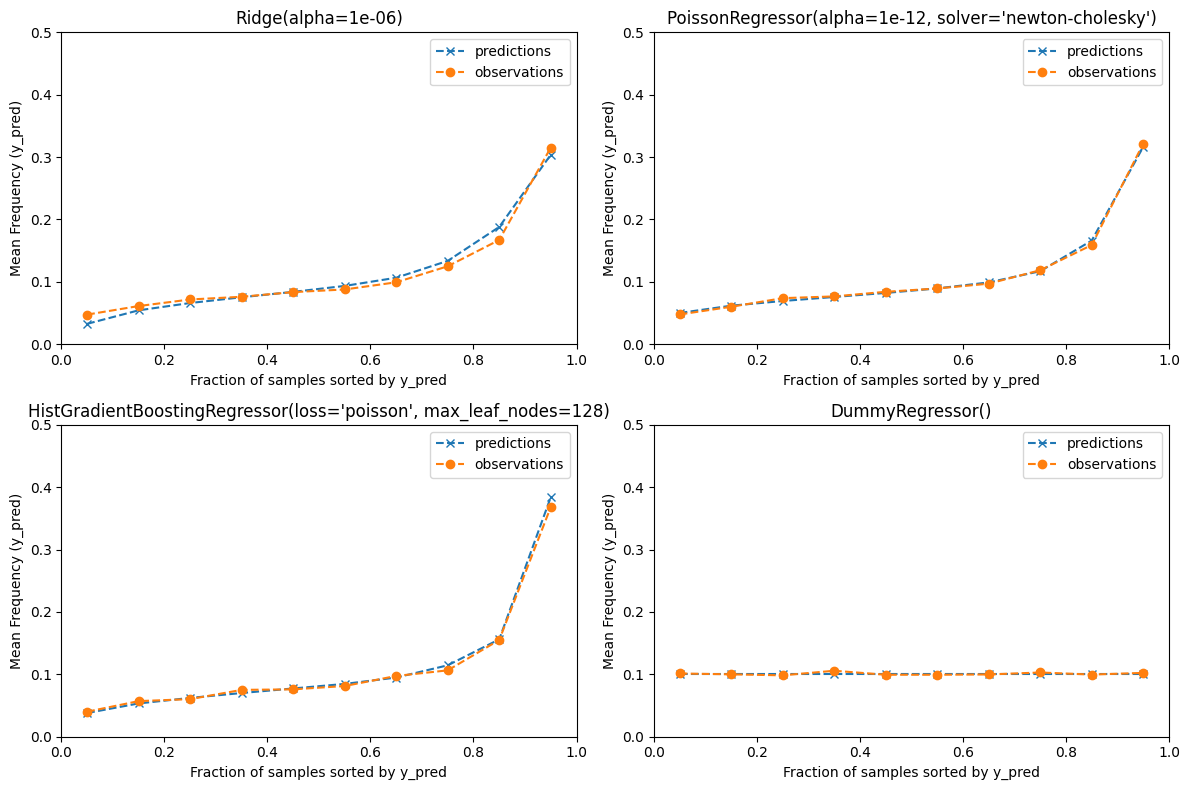

In [13]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """y_pred로 정렬된 bin에 대해 예측값과 실제값을 비교한다.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        실제 목표값
    y_pred: array-like of shape (n_samples,)
        예측된 목표값
    sample_weight : array-like of shape (n_samples,)
        샘플 가중치
    n_bins: int
        사용할 bin의 수

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin의 중심값
    y_true_bin: ndarray of shape (n_bins,)
        각 bin에 대한 평균 y_true 값
    y_pred_bin: ndarray of shape (n_bins,)
        각 bin에 대한 평균 y_pred 값
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # 파이프라인의 마지막 단계에서 사용된 추정기 이후 모델의 이름
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

## Evaluation of the ranling power

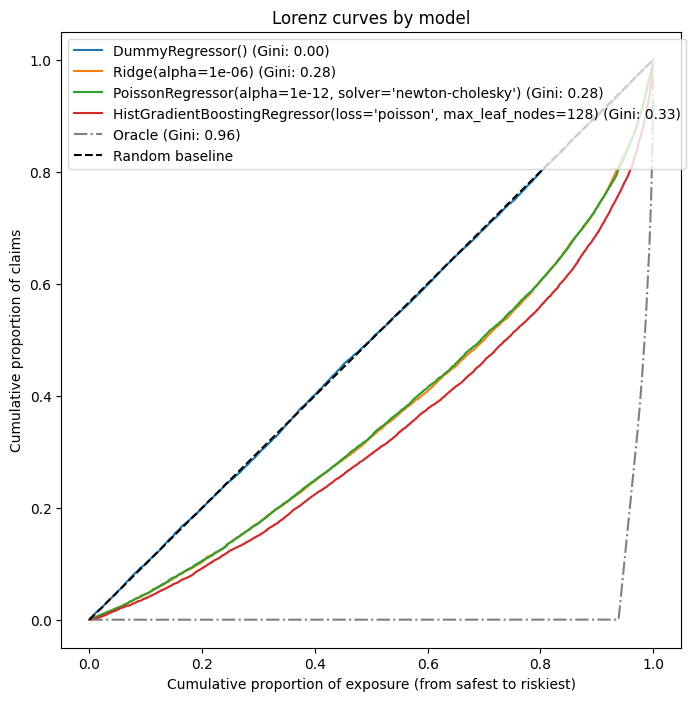

In [14]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # 예즉된 위험을 증가하는 순서대로 샘플 정렬
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# 랜덤 베이스 라인
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")